## Block-diagonal noise covariance operators (and their inverse)

This notebook shows how to create block-diagonal noise covariance operators and their inverses. Block-diagonal noise covariances model the noise when it is piecewise stationary, with no correlation between different stationary segments. They are also suitable for map-making involving TODs from multiple detectors with no correlation between them.

Similar to basic noise covariance operators and their inverses, all block-diagonal noise operators provide a `diag` attribute, which retrieves the diagonal elements of the operator, and a `get_inverse()` method that returns the inverse of the operator.

All block-diagonal noise operators are defined locally. This means that, for consistency, the user must ensure that the noise covariance and its inverse defined on each MPI process correspond to the TOD available locally on that process.

Unless otherwise mentioned explicitly, all block-diagonal (inverse) noise covariance operators can be defined using following arguments:

- `operator`  
    The base operator used to define the individual blocks of the operator
- `block_size`  
    A 1-d array containing the size of individual blocks of the operator
- `block_input`
    A list of 1-d arrays containing the noise properties of individual blocks of the operator in terms of noise covariance or power spectrum. The number of arrays in the list must be same as the number of elements in `block_size`. The size of the input arrays must correspond to the block size specified in `block_size`.
- `input_type`  
    The name of the noise property. If `block_input` argument contains the noise covariances, `input_type` must be `"covariance"`. Likewise, if the `block_input` argument contains the power spectrum arrays, the `input_type` must be `power_spectrum`.
- `dtype`  
    The data-type of the operator

It is also possible to create a block-diagonal operator with different types of blocks.  A relevant example is provided at the end of this notebook.

<div class="alert alert-block alert-warning">

**NOTE**  
The linear operators defined in BrahMap can be visualized using the `brahmap.utilities.plot_LinearOperator()` function. This function requires `matplotlib` to be installed. However, it must be used very carefully, as it allocates a large array in memory - matching the dimensions of the linear operator - which can quickly crash your system. In these examples, we use this function because our operators are very small.

</div>


In [ ]:
### If you are using Google Colab, uncomment the following line and execute this cell to install the required packages

# %pip install matplotlib git+https://github.com/anand-avinash/BrahMap.git

In [1]:
import brahmap
from brahmap.utilities import plot_LinearOperator
import numpy as np

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


### Block-diagonal noise covariance with diagonal covariance blocks

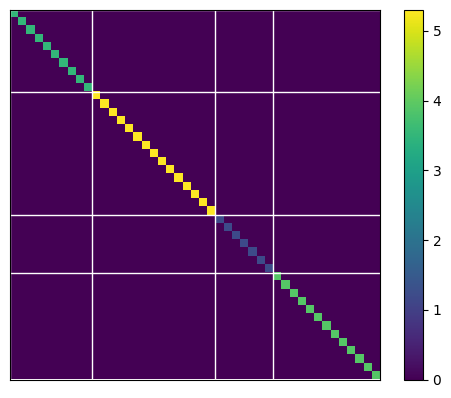

In [2]:
### Block-diagonal noise covariance operator with diagonal blocks of different variances

blkdiag_diag_noise_cov = brahmap.BlockDiagNoiseCovLO(
    operator=brahmap.NoiseCovLO_Diagonal,
    block_size=[10, 15, 7, 13],
    block_input=[3.5, 5.3, 1.2, 3.9],
    input_type="covariance",
    dtype=np.float32,
)

### Visualizing the operator
plot_LinearOperator(blkdiag_diag_noise_cov)

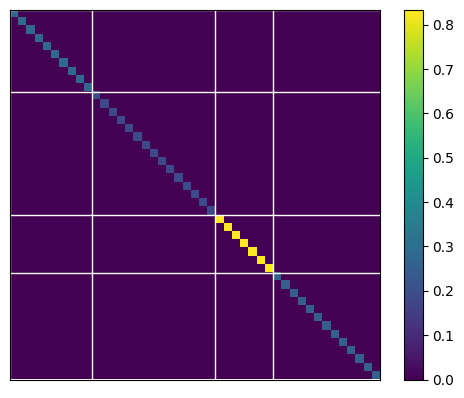

In [3]:
### Block-diagonal inverse noise covariance operator with diagonal blocks of different variances

blkdiag_inv_diag_noise_cov = brahmap.BlockDiagInvNoiseCovLO(
    operator=brahmap.InvNoiseCovLO_Diagonal,
    block_size=[10, 15, 7, 13],
    block_input=[3.5, 5.3, 1.2, 3.9],
    input_type="covariance",
    dtype=np.float32,
)

### Visualizing the operator
plot_LinearOperator(blkdiag_inv_diag_noise_cov)

In [4]:
### We can verify that the product of the noise covariance and the inverse noise covariance is an identity

mat_prod_diag = (blkdiag_diag_noise_cov * blkdiag_inv_diag_noise_cov).to_array()

# Identity operator of size same as the block-diagonal operator
identity_diag = np.eye(blkdiag_diag_noise_cov.size)

np.testing.assert_allclose(
    mat_prod_diag,
    identity_diag,
    rtol=1.0e-6,
    atol=1.0e-6,
)

### Block-diagonal noise covariance with circulant covariance blocks

In [5]:
### Defining the list of covariance and power spectrum arrays

# Block size
blk_size_circ = [10, 12, 8, 20]

# List of simple 1/f spectrum
list_ps_circ = []
for idx, size in enumerate(blk_size_circ):
    freqs = np.fft.fftfreq(size)
    ps = np.zeros(size)
    ps[1:] = 10 / np.abs(freqs[1:])
    ps[0] = 500
    list_ps_circ.append(ps)

# List of self covariance computed from power spectrum
list_cov_circ = []
for ps in list_ps_circ:
    cov = np.fft.ifft(ps).real
    list_cov_circ.append(cov)

In [6]:
### Defining block-diagonal noise covariance with circulant blocks, and self covariance as input
blkdiag_circ_noise_cov1 = brahmap.BlockDiagNoiseCovLO(
    operator=brahmap.NoiseCovLO_Circulant,
    block_size=blk_size_circ,
    block_input=list_cov_circ,
    input_type="covariance",
    dtype=np.float32,
)

### Defining block-diagonal noise covariance with circulant blocks, and power spectrum as input
blkdiag_circ_noise_cov2 = brahmap.BlockDiagNoiseCovLO(
    operator=brahmap.NoiseCovLO_Circulant,
    block_size=blk_size_circ,
    block_input=list_ps_circ,
    input_type="power_spectrum",
    dtype=np.float32,
)

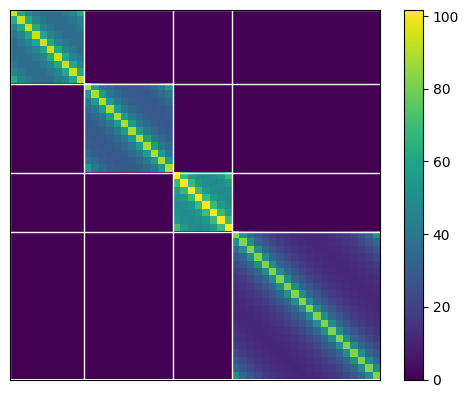

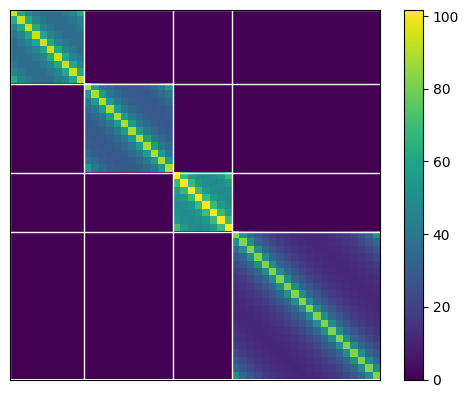

In [7]:
### Visualizing the two operators
plot_LinearOperator(blkdiag_circ_noise_cov1)
plot_LinearOperator(blkdiag_circ_noise_cov2)

In [8]:
### We can verify that the two operators defined above are equal

np.testing.assert_allclose(
    blkdiag_circ_noise_cov1.to_array(),
    blkdiag_circ_noise_cov2.to_array(),
    rtol=1.0e-5,
    atol=1.0e-8,
)

In [9]:
### Defining block-diagonal inverse noise covariance with circulant blocks, and self covariance as input
blkdiag_inv_circ_noise_cov1 = brahmap.BlockDiagInvNoiseCovLO(
    operator=brahmap.InvNoiseCovLO_Circulant,
    block_size=blk_size_circ,
    block_input=list_cov_circ,
    input_type="covariance",
    dtype=np.float32,
)

### Defining block-diagonal inverse noise covariance with circulant blocks, and power spectrum as input
blkdiag_inv_circ_noise_cov2 = brahmap.BlockDiagInvNoiseCovLO(
    operator=brahmap.InvNoiseCovLO_Circulant,
    block_size=blk_size_circ,
    block_input=list_ps_circ,
    input_type="power_spectrum",
    dtype=np.float32,
)

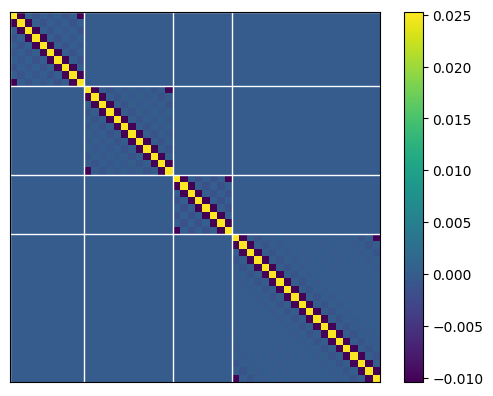

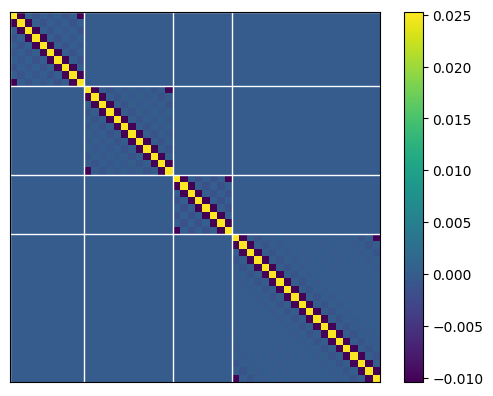

In [10]:
### Visualizing the two operators
plot_LinearOperator(blkdiag_inv_circ_noise_cov1)
plot_LinearOperator(blkdiag_inv_circ_noise_cov2)

In [11]:
### We can verify that the two operators defined above are equal

np.testing.assert_allclose(
    blkdiag_inv_circ_noise_cov1.to_array(),
    blkdiag_inv_circ_noise_cov2.to_array(),
    rtol=1.0e-5,
    atol=1.0e-8,
)

In [12]:
### We can also verify that the product of the two operators is an identity

mat_prod_circ = (blkdiag_circ_noise_cov1 * blkdiag_inv_circ_noise_cov1).to_array()

# Identity operator of size same as the block-diagonal operator
identity_circ = np.eye(blkdiag_circ_noise_cov1.size)

np.testing.assert_allclose(
    mat_prod_circ,
    identity_circ,
    rtol=1.0e-6,
    atol=1.0e-6,
)

### Block-diagonal noise covariance with Toeplitz covariance blocks

In [13]:
### Defining the list of covariance and power spectrum arrays

# Block size
blk_size_toep = [10, 12, 8, 20]

# List of simple 1/f spectrum
list_ps_toep = []
for idx, size in enumerate(blk_size_toep):
    ps_size = 2 * size - 1
    freqs = np.fft.fftfreq(ps_size)
    ps = np.zeros(ps_size)
    ps[1:] = 10 / np.abs(freqs[1:])
    ps[0] = 500
    list_ps_toep.append(ps)

# List of self covariance computed from power spectrum
list_cov_toep = []
for idx, size in enumerate(blk_size_toep):
    cov = np.fft.ifft(list_ps_toep[idx]).real[:size]
    list_cov_toep.append(cov)

In [14]:
### Defining block-diagonal noise covariance with Toeplitz blocks, and self covariance as input
blkdiag_toep_noise_cov1 = brahmap.BlockDiagNoiseCovLO(
    operator=brahmap.NoiseCovLO_Toeplitz01,
    block_size=blk_size_toep,
    block_input=list_cov_toep,
    input_type="covariance",
    dtype=np.float32,
)

### Defining block-diagonal noise covariance with Toeplitz blocks, and power spectrum as input
blkdiag_toep_noise_cov2 = brahmap.BlockDiagNoiseCovLO(
    operator=brahmap.NoiseCovLO_Toeplitz01,
    block_size=blk_size_toep,
    block_input=list_ps_toep,
    input_type="power_spectrum",
    dtype=np.float32,
)

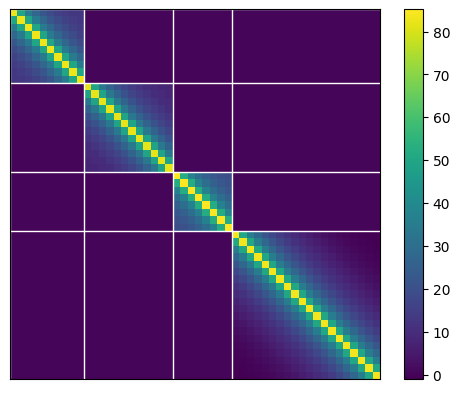

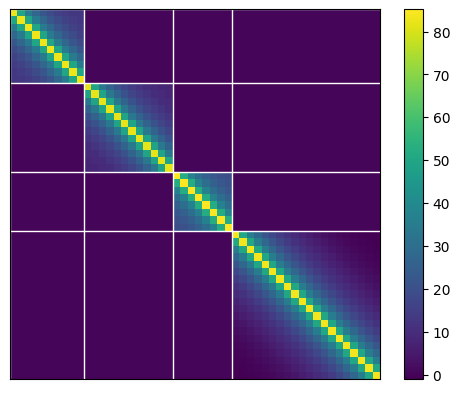

In [15]:
### Visualizing the two operators
plot_LinearOperator(blkdiag_toep_noise_cov1)
plot_LinearOperator(blkdiag_toep_noise_cov2)

In [16]:
### We can verify that the two operators defined above are equal

np.testing.assert_allclose(
    blkdiag_toep_noise_cov1.to_array(),
    blkdiag_toep_noise_cov2.to_array(),
    rtol=1.0e-5,
    atol=1.0e-8,
)

In [17]:
### Defining block-diagonal inverse noise covariance with Toeplitz blocks, and self covariance as input
blkdiag_inv_toep_noise_cov1 = brahmap.BlockDiagInvNoiseCovLO(
    operator=brahmap.InvNoiseCovLO_Toeplitz01,
    block_size=blk_size_toep,
    block_input=list_cov_toep,
    input_type="covariance",
    dtype=np.float32,
)

### Defining block-diagonal inverse noise covariance with Toeplitz blocks, and power spectrum as input
blkdiag_inv_toep_noise_cov2 = brahmap.BlockDiagInvNoiseCovLO(
    operator=brahmap.InvNoiseCovLO_Toeplitz01,
    block_size=blk_size_toep,
    block_input=list_ps_toep,
    input_type="power_spectrum",
    dtype=np.float32,
)

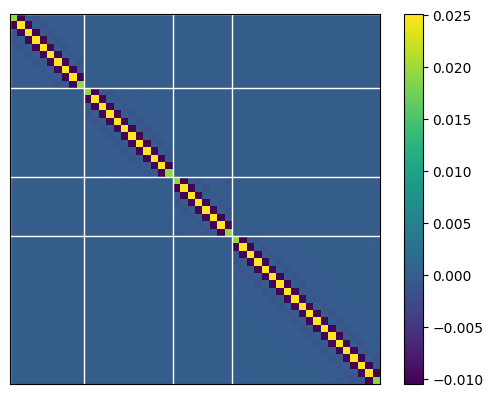

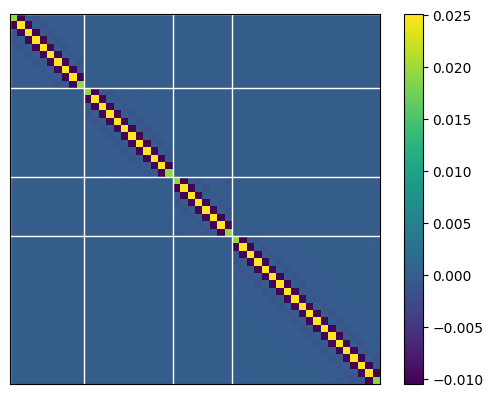

In [18]:
### Visualizing the two operators
plot_LinearOperator(blkdiag_inv_toep_noise_cov1)
plot_LinearOperator(blkdiag_inv_toep_noise_cov2)

In [19]:
### We can verify that the two operators defined above are equal

np.testing.assert_allclose(
    blkdiag_inv_toep_noise_cov1.to_array(),
    blkdiag_inv_toep_noise_cov2.to_array(),
    rtol=1.0e-5,
    atol=1.0e-8,
)

In [20]:
### We can also verify that the product of the two operators is an identity

mat_prod_toep = (blkdiag_toep_noise_cov1 * blkdiag_inv_toep_noise_cov1).to_array()

# Identity operator of size same as the block-diagonal operator
identity_toep = np.eye(blkdiag_toep_noise_cov1.size)

np.testing.assert_allclose(
    mat_prod_toep,
    identity_toep,
    rtol=1.0e-5,
    atol=1.0e-5,
)

### Block-diagonal noise covariance with different types of covariance blocks

In this example, we will create a block-diagonal noise covariance matrix and its inverse, where the first diagonal block will be Toeplitz, the second will be diagonal, and the third will be circulant. To do this, we must define each block operator individually and pass them together as a list to the base class for block-diagonal noise operator.

In [21]:
rng = np.random.default_rng(seed=5445)

In [22]:
### Creating the Toeplitz noise operators

# Generating self covariance
size_toep = 12
covariance_toep = rng.integers(low=4, high=25, size=size_toep)
covariance_toep[0] = 50

# Creating the Toeplitz noise covariance operator
toep_op = brahmap.NoiseCovLO_Toeplitz01(
    size=size_toep,
    input=covariance_toep,
    input_type="covariance",
    dtype=np.float32,
)

# Creating the inverse Toeplitz noise covariance operator
inv_toep_op = brahmap.InvNoiseCovLO_Toeplitz01(
    size=size_toep,
    input=covariance_toep,
    input_type="covariance",
    dtype=np.float32,
)

In [23]:
### Creating the diagonal noise operators

size_diag = 6
covariance_diag = 7.9

# Creating the diagonal noise covariance operator
diag_op = brahmap.NoiseCovLO_Diagonal(
    size=size_diag,
    input=covariance_diag,
    input_type="covariance",
    dtype=np.float32,
)

# Creating the inverse diagonal noise covariance operator
inv_diag_op = brahmap.InvNoiseCovLO_Diagonal(
    size=size_diag,
    input=covariance_diag,
    input_type="covariance",
    dtype=np.float32,
)

In [24]:
### Creating the circulant noise operators

# Generating the Circulant covariance
size_circ = 6
covariance_circ = rng.integers(low=2, high=20, size=int(size_circ / 2) + 1)
covariance_circ[0] = 40
if size_circ % 2 == 0:
    covariance_circ = np.concatenate([covariance_circ, covariance_circ[1:-1][::-1]])
else:
    covariance_circ = np.concatenate([covariance_circ, covariance_circ[1:][::-1]])

# Creating the circulant noise covariance operator
circ_op = brahmap.NoiseCovLO_Circulant(
    size=size_circ,
    input=covariance_circ,
    input_type="covariance",
    dtype=np.float32,
)

# Creating the inverse circulant noise covariance operator
inv_circ_op = brahmap.InvNoiseCovLO_Circulant(
    size=size_circ,
    input=covariance_circ,
    input_type="covariance",
    dtype=np.float32,
)

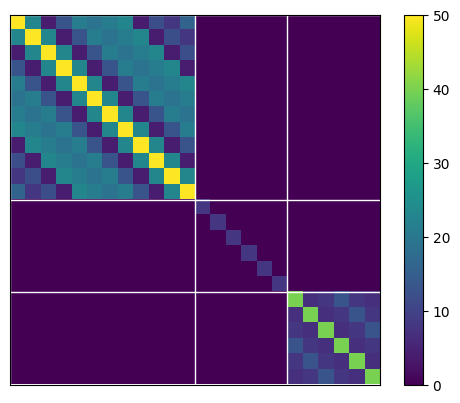

In [25]:
### Creating the block-diagonal noise covariance operator

# As we have already prepared the individual block operators, we just need to put
# them in a list and pass it to the base class of block-diagonal noise covariance
# operator
cov_op_list = [toep_op, diag_op, circ_op]

blkdiag_op = brahmap.base.BaseBlockDiagNoiseCovLinearOperator(
    block_list=cov_op_list,
)

### Visualizing the operator
plot_LinearOperator(blkdiag_op)

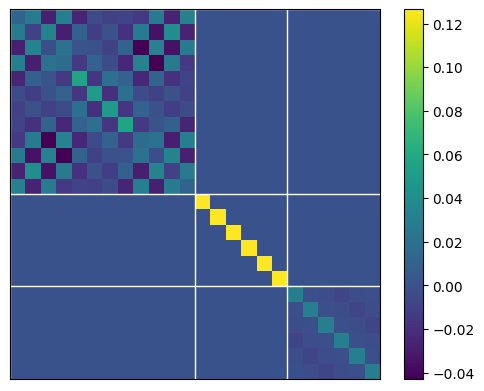

In [26]:
### Creating the block-diagonal inverse noise covariance operator

# As we have already prepared the individual block operators, we just need to put
# them in a list and pass it to the base class of block-diagonal inverse noise covariance
# operator
inv_cov_op_list = [inv_toep_op, inv_diag_op, inv_circ_op]

inv_blkdiag_op = brahmap.base.BaseBlockDiagInvNoiseCovLinearOperator(
    block_list=inv_cov_op_list,
)

### Visualizing the operator
plot_LinearOperator(inv_blkdiag_op)

In [27]:
### As always, we can also verify that the product of the two operators is an identity

mat_prod_blkdiag = (blkdiag_op * inv_blkdiag_op).to_array()

# Identity operator of size same as the block-diagonal operator
identity_blkdiag = np.eye(blkdiag_op.size)

np.testing.assert_allclose(
    mat_prod_blkdiag,
    identity_blkdiag,
    rtol=1.0e-5,
    atol=1.0e-5,
)